# Text Classification using BERT

We will build a model to perform sentiment analysis on a dataset of IMBD movie reviews.

We will need to preprocess the text appropriately, followed by building our model by combining BERT with a classifier, followed by training the model and fine-tuning BERT as a part of that.



### BERT

BERT computes vector-space representations of natural language suitable for deep learning models. BERT models use the Transformer encoder architecture to process each token of input text in full context of the tokens. before and after.

### Setup

In [1]:
!pip install -q -U tensorflow-text
!pip install -q tf-models-official

     |████████████████████████████████| 4.4 MB 13.2 MB/s 
     |████████████████████████████████| 1.8 MB 11.0 MB/s 
     |████████████████████████████████| 211 kB 44.7 MB/s 
     |████████████████████████████████| 90 kB 9.5 MB/s 
     |████████████████████████████████| 43 kB 1.9 MB/s 
     |████████████████████████████████| 636 kB 42.7 MB/s 
     |████████████████████████████████| 37.1 MB 49 kB/s 
     |████████████████████████████████| 1.1 MB 52.5 MB/s 
     |████████████████████████████████| 352 kB 35.6 MB/s 
     |████████████████████████████████| 99 kB 10.1 MB/s 
     |████████████████████████████████| 1.2 MB 39.6 MB/s 


In [2]:
import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer

import matplotlib.pyplot as plt

tf.get_logger().setLevel('ERROR')

### Sentiment Analysis

Our model will classify movie reviews as either *positive* or *negative*

### Dataset

We use the [Large Movie Review Dataset](https://ai.stanford.edu/~amaas/data/sentiment/)

In [3]:
url = 'https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz'

dataset = tf.keras.utils.get_file('aclImdb_v1.tar.gz', url,
                                  untar=True, cache_dir='.',
                                  cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')

train_dir = os.path.join(dataset_dir, 'train')

# remove unused folders to make it easier to load the data
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)

84140032/84125825 [==============================] - 6s 0us/step


Create dataset; imdb dataset already contains training and testing set, so only need to create validation set:

In [4]:
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32
seed = 123

raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed)

class_names = raw_train_ds.class_names
train_ds = raw_train_ds.cache().prefetch(buffer_size=AUTOTUNE)

val_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed)

val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

test_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/test',
    batch_size=batch_size)

test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.
Found 25000 files belonging to 2 classes.


### BERT model selection

There are many BERT models to select from with varying sizes, pre-trained weights and objectives. For computation efficiency, we choose to use [Small BERTs](https://tfhub.dev/google/collections/bert/1).

#### Preprocessing BERT
We need to transform the text inputs to numeric token ids and arrange them in several tensors before inputting them into BERT. We will load the preprocessing model into a [hub.KerasLayer](https://www.tensorflow.org/hub/api_docs/python/hub/KerasLayer) to compose our fine-tuned model.


In [6]:
bert_model_name = 'small_bert/bert_en_uncased_L-4_H-512_A-8'
tfhub_handle_encoder = 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1'
tfhub_handle_preprocess = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'

bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

After the preprocessed model processes a text corpus, along with the keys it contains the outputs`input_words_id, input_mask, input_type_ids` which the BERT model would use.

#### Using BERT

In [8]:
bert_model = hub.KerasLayer(tfhub_handle_encoder)

After feeding the BERT model the output from the `bert_preprocess_model`, the BERT model returns a map with keys `pooled_output, sequence_output, encoder_output`:
- `pooled_output` is a `[batch_size, H]` tensor representing each input sequence as a whole, similar to an embedding for the entire movie review.
- `sequence_output` is a `[batch_size, seq_length, H]` tensor representing each input token in the context, similar to a contextual embedding for every token in the movie review.
- `encoder_outputs` are the intermediate activations of the `L` Transformer blocks. `outputs["encoder_outputs"][i]` is a `[batch_size, seq_length, 1024]` tensor with the outputs of the i-th Transformer block, for `0 <= i < L`. The last value of the list is equal to `sequence_output`.

For the fine-tuning we use the `pooled_output` array.

### Model Definition

Our model will consist of the preprocessing model, the small BERT model, followed by a Dropout and Dense layer for classification.

In [10]:
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
  return tf.keras.Model(text_input, net)

### Model Training

#### Loss function
We use `BinaryCrossentroy` since this is a binary classification problem


In [13]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()

#### Optimizer

We use the same optimizer that BERT is trained with in the [BERT paper](https://arxiv.org/abs/1810.04805), a varient of Adam that incorporates weight decay, [AdamW](https://arxiv.org/abs/1711.05101)

For the learning rate (`init_lr`), we use the same schedule as BERT pre-training: linear decay of a notional initial learning rate, prefixed with a linear warm-up phase over the first 10% of training steps (`num_warmup_steps`). In line with the BERT paper, the initial learning rate is smaller for fine-tuning (best of 5e-5, 3e-5, 2e-5).

In [14]:
epochs = 5
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

Compile Model and Train:

In [15]:
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

history = classifier_model.fit(x=train_ds,
                               validation_data=val_ds,
                               epochs=epochs)

Epoch 1/5
625/625 [==============================] - 301s 472ms/step - loss: 0.5000 - binary_accuracy: 0.7326 - val_loss: 0.4091 - val_binary_accuracy: 0.7966
Epoch 2/5
625/625 [==============================] - 289s 462ms/step - loss: 0.3335 - binary_accuracy: 0.8515 - val_loss: 0.3611 - val_binary_accuracy: 0.8338
Epoch 3/5
625/625 [==============================] - 290s 464ms/step - loss: 0.2564 - binary_accuracy: 0.8913 - val_loss: 0.4181 - val_binary_accuracy: 0.8302
Epoch 4/5
625/625 [==============================] - 290s 464ms/step - loss: 0.1925 - binary_accuracy: 0.9226 - val_loss: 0.4426 - val_binary_accuracy: 0.8488
Epoch 5/5
625/625 [==============================] - 288s 461ms/step - loss: 0.1578 - binary_accuracy: 0.9401 - val_loss: 0.4479 - val_binary_accuracy: 0.8542


### Model Evaluation


Performance on test set:

In [16]:
loss, accuracy = classifier_model.evaluate(test_ds)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

782/782 [==============================] - 148s 189ms/step - loss: 0.4529 - binary_accuracy: 0.8562
Loss: 0.45285657048225403
Accuracy: 0.8561599850654602


Model performance during training:

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


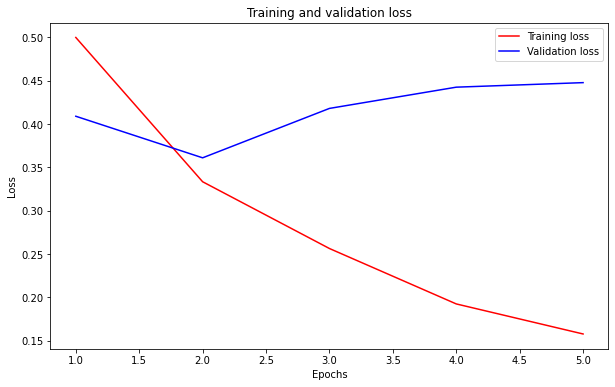

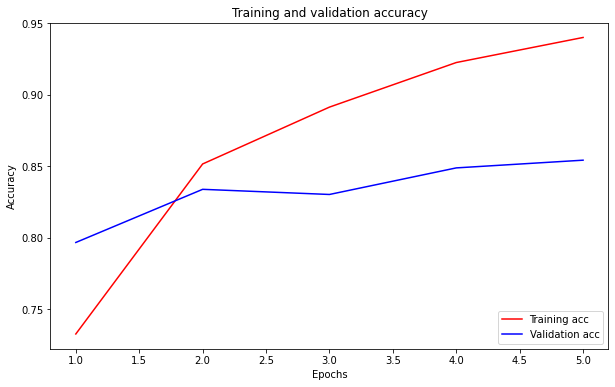

In [26]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

fig = plt.figure(figsize=(10, 6))
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()